In [ ]:
### https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle/notebook

we will use below list of technique

1. tfidf
2. count features
3. logistic regression
4. naive bayes
5. svm
6. xgboost
7. grid search
8. word vectors
9. LSTM
10. GRU
11. Ensembling

In [ ]:
 import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
df_train= pd.read_csv("/content/drive/MyDrive/ML_DATASET/spooky/train.csv")
df_test= pd.read_csv("/content/drive/MyDrive/ML_DATASET/spooky/test.csv")
df_sample= pd.read_csv("/content/drive/MyDrive/ML_DATASET/spooky/sample_submission.csv")

In [ ]:
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [ ]:
df_test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [ ]:
df_sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [ ]:
print("Train Shape: ", df_train.shape)
print("===============================")
print("Test Shape: ", df_test.shape)
print("===============================")
print("sample Shape: ", df_sample.shape)

Train Shape:  (19579, 3)
Test Shape:  (8392, 2)
sample Shape:  (8392, 4)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Train Data Analysis')

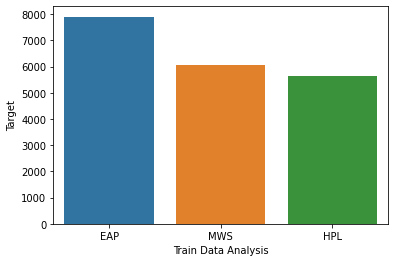

In [ ]:
x = df_train.author.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel("Target")
plt.gca().set_xlabel("Train Data Analysis")

**Multiclass Lebels**
The problem requires us to predict the author, i.e. EAP, HPL and MWS given the text. In simpler words, text classification with 3 different classes.

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

# **Using Label Encoder**
 Convert text to labels into 0,1,2

In [ ]:
lblEncoder = preprocessing.LabelEncoder()
y = lblEncoder.fit_transform(df_train.author.values)

In [ ]:
# set(y)

Splitting Data set in Train and Test using **model_selection**

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

 **stratify** It is used to split random data based on classifier labels 

In [ ]:
print (xtrain.shape)
print (xvalid.shape)

(17621,)
(1958,)


## Building Basic Models¶
Let's start building our very first model.


In [ ]:
tfv = TfidfVectorizer(min_df = 3, max_features=None, strip_accents='unicode',
                        analyzer='word', token_pattern=r'\w{1,}',
                        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
                        stop_words = 'english')

In [ ]:
# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) +  list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.572 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Let's use another approach to get more better result **CountVectorizer**

In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

ctv.fit(list(xtrain) + list(xvalid))
cv_train = ctv.transform(xtrain)
cv_test = ctv.transform(xvalid)

In [ ]:
# Fitting a simple Logistic Regression on CV
clf = LogisticRegression(C=1.0)
clf.fit(cv_train, ytrain)
predictions = clf.predict_proba(cv_test)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.527 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


We found improvement in logloss! and looks better than **TFIDF**

Now trying to change Model using **Naive Bayes on CV**

In [ ]:
clf = MultinomialNB()
clf.fit(cv_train, ytrain)
predictions = clf.predict_proba(cv_test)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.485 


Now we got much better than Logistic regression using Naive Bayes 

In [ ]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [ ]:
xtrain_svd

array([[ 0.041897  , -0.00794377, -0.0053988 , ...,  0.02402336,
         0.02012188, -0.00315865],
       [ 0.08478728,  0.22555022,  0.00421333, ..., -0.00334057,
         0.0168713 ,  0.03786612],
       [ 0.05793769, -0.02006542,  0.0009317 , ..., -0.01340451,
         0.00251665,  0.03805849],
       ...,
       [ 0.02381288,  0.00071342, -0.00050204, ..., -0.05575203,
        -0.02014242, -0.00995765],
       [ 0.08784847, -0.00655745, -0.00982831, ...,  0.02085094,
        -0.04386557, -0.03563842],
       [ 0.01994066, -0.00104047, -0.00034871, ...,  0.00039374,
         0.00113875,  0.00843948]])

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.735 


Oops! time to get up! Looks like SVM doesn't perform well on this data...!

Before moving further, lets apply the most popular algorithm on Kaggle: xgboost!

# TFIDF

In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.782 


In [ ]:
xvalid_tfv.tocsc()

<1958x15102 sparse matrix of type '<class 'numpy.float64'>'
	with 22260 stored elements in Compressed Sparse Column format>

# CV - CountVectorizer

In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(cv_train, ytrain)
predictions = clf.predict_proba(cv_test)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.773 


In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.817 


**Creating scorer **

In [ ]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [ ]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [ ]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [ ]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1,  refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Best score: -0.739
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


In [ ]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: -0.492
Best parameters set:
	nb__alpha: 0.1


# Word Vectors¶


1. GloVe vectors
2. word2vec
3. fasttext

In [ ]:
embedding_dict={}
with open('/content/drive/MyDrive/ML_DATASET/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()
print('Found %s word vectors.' % len(embedding_dict))

Found 210185 word vectors.


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = s.lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embedding_dict[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 1958/1958 [00:00<00:00, 2911.04it/s]


In [ ]:
xvalid_glove = np.array(xvalid_glove, dtype=object)
xtrain_glove = np.array(xtrain_glove, dtype=object)

NameError: ignored

In [ ]:
xtrain_glove.shape

(17621,)

In [ ]:
ytrain.shape

(17621,)

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)

In [ ]:
clf.fit(xtrain_glove, ytrain)

IndexError: ignored

In [ ]:
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

IndexError: ignored

# Deep Learning¶

In [ ]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop_words))]
        corpus.append(words)
    return corpus

In [ ]:
df = df_train.append(df_test)
corpus=create_corpus(df)

100%|██████████| 27971/27971 [00:08<00:00, 3360.86it/s]


In [ ]:
ytrain

array([2, 0, 2, ..., 0, 2, 2])

In [ ]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [ ]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(xtrain_glove, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1,  validation_data=(xvalid_glove, yvalid_enc))

ValueError: ignored

In [ ]:
y_pre=model.predict(xtest_glove)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id': df_submission['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

============================================================


In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 25943/25943 [00:00<00:00, 181414.58it/s]


In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=5, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/5
35/35 [==============================] - 48s 1s/step - loss: 0.8833 - val_loss: 0.7997
Epoch 2/5
35/35 [==============================] - 44s 1s/step - loss: 0.8644 - val_loss: 0.7854
Epoch 3/5
35/35 [==============================] - 48s 1s/step - loss: 0.8527 - val_loss: 0.7946
Epoch 4/5
35/35 [==============================] - 40s 1s/step - loss: 0.8415 - val_loss: 0.7585
Epoch 5/5
35/35 [==============================] - 40s 1s/step - loss: 0.8246 - val_loss: 0.7633


# **Early Stopping**

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=10, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/10
35/35 [==============================] - 129s 4s/step - loss: 1.0806 - val_loss: 0.9626
Epoch 2/10
35/35 [==============================] - 125s 4s/step - loss: 0.9840 - val_loss: 0.8907
Epoch 3/10
35/35 [==============================] - 123s 4s/step - loss: 0.9414 - val_loss: 0.8545
Epoch 4/10
35/35 [==============================] - 125s 4s/step - loss: 0.9164 - val_loss: 0.8512
Epoch 5/10
35/35 [==============================] - 124s 4s/step - loss: 0.9085 - val_loss: 0.8517
Epoch 6/10
35/35 [==============================] - 125s 4s/step - loss: 0.8940 - val_loss: 0.8221
Epoch 7/10
35/35 [==============================] - 126s 4s/step - loss: 0.8657 - val_loss: 0.7913
Epoch 8/10
35/35 [==============================] - 123s 4s/step - loss: 0.8527 - val_loss: 0.7955
Epoch 9/10
35/35 [==============================] - 125s 4s/step - loss: 0.8321 - val_loss: 0.7816
Epoch 10/10
35/35 [==============================] - 123s 4s/step - loss: 0.8182 - val_loss: 0.7267


In [ ]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=5, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/5
35/35 [==============================] - 307s 7s/step - loss: 1.0787 - val_loss: 0.9903
Epoch 2/5
35/35 [==============================] - 260s 7s/step - loss: 0.9730 - val_loss: 0.8726
Epoch 3/5
35/35 [==============================] - 260s 7s/step - loss: 0.9496 - val_loss: 0.8951
Epoch 4/5
35/35 [==============================] - 271s 8s/step - loss: 0.9265 - val_loss: 0.8859
Epoch 5/5
35/35 [==============================] - 266s 8s/step - loss: 0.9089 - val_loss: 0.8329


**Pretty close! Lets try two layers of GRU:**



In [ ]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Epoch 1/100
35/35 [==============================] - 272s 8s/step - loss: 1.0895 - val_loss: 1.0057
Epoch 2/100
35/35 [==============================] - 262s 7s/step - loss: 1.0151 - val_loss: 0.9325
Epoch 3/100
35/35 [==============================] - 246s 7s/step - loss: 0.9619 - val_loss: 0.9143
Epoch 4/100
35/35 [==============================] - 262s 7s/step - loss: 0.9362 - val_loss: 0.8447
Epoch 5/100
35/35 [==============================] - 260s 7s/step - loss: 0.9021 - val_loss: 0.8280
Epoch 6/100
35/35 [==============================] - 264s 8s/step - loss: 0.8840 - val_loss: 0.8235
Epoch 7/100
35/35 [==============================] - 265s 8s/step - loss: 0.8579 - val_loss: 0.7804
Epoch 8/100
35/35 [==============================] - 260s 7s/step - loss: 0.8372 - val_loss: 0.7915
Epoch 9/100
35/35 [==============================] - 261s 7s/step - loss: 0.8186 - val_loss: 0.7669
Epoch 10/100
 8/35 [=====>........................] - ETA: 3:27 - loss: 0.8058

# Ensembling